# SBI: inference and diagnostics

- load the results of the sampling
- train the estimator
- infer a parameter from synthetic data
- assess the result

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import numpy as np

In [3]:
import torch

/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tvb_inversion import utils

/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [5]:
from tvb_inversion.sbi.inference import zscore, shrinkage

In [6]:
from tvb_inversion.sbi import EstimatorSBI, Prior

In [7]:
from sbi.utils import torchutils

In [8]:
import pandas as pd

We start with loadin the pre-computed summary statistics for simulations performed for parameters sampled from the prior defined in the previous notebook.

In [9]:
x_all = pd.read_csv(utils.data_path('demo_prior_samples.csv.gz'))
#x_all =  torch.load(utils.data_path('1/x_all.pt'))

In [10]:
x_all

,FC_SUM,FCD_SUM
0,1926.0238,4054.915800
1,1538.3922,703.786440
2,1639.9231,192.917130
3,1885.4988,4530.793000
4,1860.8954,45.790524
...,...,...
7655,3394.0250,859.420650
7656,1827.1853,80.235050
7657,2417.3792,-39.461117
7658,2262.0457,-122.892290


In [11]:
x_fc = x_all.to_numpy()[:,[0]]
x_fcd = x_all.to_numpy()[:,[1]]

Now we need to reconstruct the prior. One could also save it as a torch `.pt` file.

In [13]:
# prior =  torch.load(utils.data_path('prior.pt'))

prior_G_min, prior_G_max = [0.1], [1.2]

prior_dist = torchutils.BoxUniform(
    low=torch.as_tensor(prior_G_min),
    high=torch.as_tensor(prior_G_max))

prior = Prior(['coupling.a'], prior_dist)

The parameters $\theta$ sampled from the prior corresponding to the prior sample.

In [14]:
theta = pd.read_csv(utils.data_path('demo_theta.csv.gz'))
theta

,coupling.a
0,0.797487
1,0.639103
2,0.601191
3,0.795537
4,0.483783
...,...
7655,1.178222
7656,0.501154
7657,0.310969
7658,0.375458


In [15]:
theta = torch.as_tensor(theta.values, dtype=torch.float32)

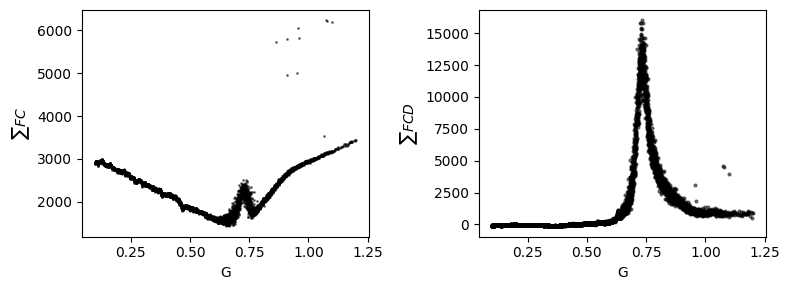

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
ax = axs[0]
ax.plot(theta[:, 0], x_fc, "ko", ms=1, alpha=0.5)
ax.set(xlabel="G", ylabel=r"$\sum FC$")

ax = axs[1]
ax.plot(theta[:, 0], x_fcd, "ko", ms=2, alpha=0.5)
ax.set(xlabel="G", ylabel=r"$\sum FCD$")

fig.tight_layout()

Next we will choose the ground truth for the parameter we want to infer. In this case (for demonstration purposes) we choose the maximum of the FCD sum. Feel free to explore other values!

In [17]:
index_max = np.argmax(x_fcd)
true_param = theta[index_max]

print("index max is :", index_max, true_param, x_fcd[index_max])
obs_stats_fcd = x_fcd[index_max, :]
obs_stats_fcd = obs_stats_fcd[None, :]

obs_stats_fc = x_fc[index_max, :]
obs_stats_fc = obs_stats_fc[None, :]

index max is : 3001 tensor([0.7320]) [16016.807]


Now we can train the estimator using the simulated summary statistics.

In [18]:
estimator = EstimatorSBI(prior, theta=theta)

In [19]:
posterior = estimator.train(x_fcd)

/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 182 epochs.

Having trained the estimator, we can now draw samples from the posterior distribution with respect to the observed (empirical) data.

In [20]:
num_samples = 20_000
posterior_samples = posterior.sample((num_samples,),obs_stats_fcd)

Drawing 20000 posterior samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 396203.00it/s]


In [21]:
from sbi.analysis import pairplot

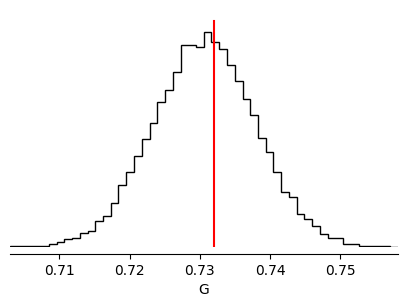

In [22]:
fig, axs = pairplot(posterior_samples, points=true_param, points_colors='r', samples_colors='k', figsize=(5,3), labels=['G']);

The posterior is centered around the ground truth. Moreover, we can assess it wiht the help of the `shrinkage` and `zscore` diagnostic functions.

In [23]:
post_std = torch.std(posterior_samples)
post_mean = torch.mean(posterior_samples)

In [24]:
prior_std = torch.std(theta)

In [25]:
shr = shrinkage(prior_std, post_std)
zsc = zscore(true_param, post_mean, post_std)

[(0.0, 1.1), Text(0.5, 0, 'z-score'), Text(0, 0.5, 'shrinkage')]

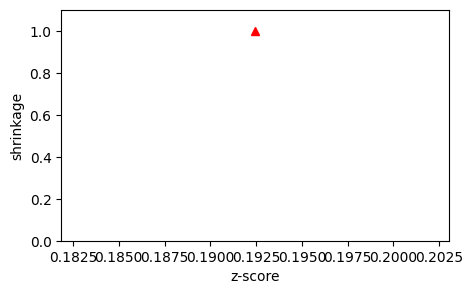

In [26]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(zsc, shr, 'r^')
ax.set(ylim=[0,1.1], xlabel='z-score', ylabel='shrinkage')

Here we can see, that the shrinkage is high (close to 1) indicating well identified posterior, while the zscore is low meaning the ground truth is accuratelly captured by the posterior distribution.